---
# Unit04: Processing passive seismic data II

This notebook has some practical processing activities of the Course **ProSeisSN**. It deals with time series processing using a passive seismic dataset using [ObsPy](https://docs.obspy.org/).

#### Dependencies: Obspy, Numpy, Matplotlib
#### Reset the Jupyter/IPython notebook in order to run it again, press:
***Kernel*** -> ***Restart & Clear Output***
#### The code $\Downarrow$ BELOW $\Downarrow$ runs a notebook with other dependencies

In [27]:
#------ Import Libraries
import sys
import os
    
#------ Work with the directory structure to include auxiliary codes
print('\n Local directory ==> ', os.getcwd())
print('  - Contents: ', os.listdir(), '\n')

path = os.path.abspath(os.path.join('..'))
if path not in sys.path:
    sys.path.append(path+"/CodePy")

%run ../CodePy/ImpMod.ipynb

#------ Alter default matplotlib rcParams
from matplotlib import rcParams
# Change the defaults of the runtime configuration settings in the global variable matplotlib.rcParams
plt.rcParams['figure.figsize'] = 9, 5
#plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams["figure.subplot.hspace"] = (.9)

#------ Magic commands
%matplotlib inline
%matplotlib widget


 Local directory ==>  /media/jandyr/082670DD2670CCE61/R-D/COURSES/COPPE_24/Github/Unit04
  - Contents:  ['.ipynb_checkpoints', 'Nbk04.ipynb'] 

ObsPy version ==> 1.2.2


---
## Read data locally

Read the low pass filtered Z-component from the event

|EventID | Time | Lat | Long | Depth(km) | Mww | Location |
| :- | :-: | :- | :- | :-: | :-: | :- |
|11793085|2024-01-20T21:31|-7.2879|-71.464|607|6.6|WESTERN BRAZIL|

recorded at station IU HKT, $44^{\circ}$ away. The data is available locally.

#### Reading options:
- Read demeaned+detrended data             ../Data/wb11793085d.mseed
- Read the tapered+low pass filtered data  ../Data/wb11793085lp.mseed

#### Estimating the highest frequency $f_{max}$
The Nyquist is the highest frequency, $f_{max}$, which can be recovered from a given digital time series without aliasing. The choice of $f_{max}$ depends on the data file.

- For the **low pass filtered data** file $f_{max}$ is a point, beyond cutoff frequency where the attenuation is $\approx40\textrm{dB}$ or $\approx1\textrm{%}$ drop in amplitude. The following snippet estimate the **FFT** of a trace:

` fNy  = ent * 1. / (2.0 * dt) ` 

` FtrZ = np.fft.rfft(trZ.data) ` 

` freq = np.linspace(0, fNy, len(FtrZ)) ` 

` freq, FtrZ = u.lmt_ValInd(freq, FtrZ, 3. * fc) `


- For the **demean+detrend, unfiltered, data** file $f_{max}$ it is possible to adopt a safety margin of $80\textrm{%}$ of $f_{Nyquist}$. The following snippet estimate the **FFT** of a trace:

` ent = input(f'-Enter a safety margin for the Nyquist (dflt: 0.8):') or '0.8' ` 

` ent = float( ent.rstrip().split(' ')[0] ) ` 

` fNy  = ent * 1. / (2.0 * dt) ` 

` FtrZ = np.fft.rfft(trZ.data) ` 

` freq = np.linspace(0, fNy, len(FtrZ)) ` 

` freq, FtrZ = u.lmt_ValInd(freq, FtrZ, ent * fNy) `

---
## Time-frequency plots - spectrograms 

Look at the data in both time- and frequency-domains, using a **spectrogram**.

### The relevant limits in time and frequency domains
- **time-domain**

$$\underset{0}{\mid}\cdot\cdotp\cdotp\cdotp\cdot\cdotp\cdotp\cdotp\underset{\delta t}{\mid\mid}\cdot\cdotp\cdotp\cdotp\cdot\cdotp\cdotp\cdotp\underset{tw}{\!\cdotp\!\mid}$$

- **frequency-domain**

$$\underset{0}{\mid}\cdotp\!\underset{f_{min}}{\cdotp\cdotp\mid\cdotp\cdotp}
\cdot\cdotp\cdotp\cdotp\cdot\cdotp\cdotp\cdotp\underset{\delta f}{\mid\mid}\cdot\cdotp\cdotp\cdotp\cdot\cdotp\cdotp\cdotp\underset{\zeta f_{Ny}}{\cdotp\cdotp\mid\cdotp\cdotp}\cdotp\underset{f_{Ny}}{\!\cdotp\!\mid}$$

>> Enter d (demean+detrend) or f (filtered) data: (rtn = d):
-Enter a safety margin for the Nyquist (dflt: 0.8):
- The adopted Nyquist with a 80.0% margin is 40.0Hz
- The sampling frequency is df = 100.0Hz
- The time window is tw = 350.0s, with npts = 35001 samples
- A lower frequency estimate is lf = 0.00143Hz

IU.HKT.00.HHZ | 2024-01-20T21:36:49.028394Z - 2024-01-20T21:42:39.028394Z | 100.0 Hz, 35001 samples


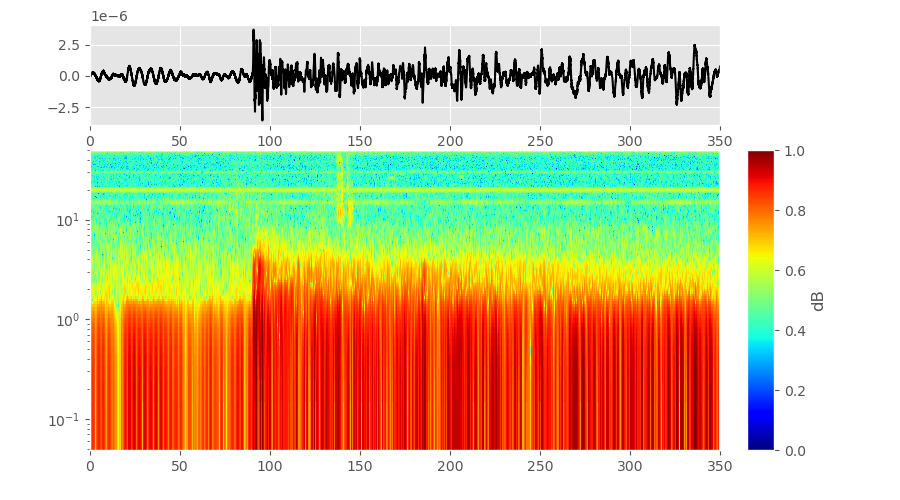

In [28]:
#%%script echo skipping
"""
=========== READ THE DATA LOCALLY ===========
"""
dummy = input(f'>> Enter d (demean+detrend) or f (filtered) data: (rtn = d):') or 'd'
#
if dummy == 'f':
    filename = '../Data/wb11793085lp.mseed'
#------- Read the low pass filtered data file
    st = read(filename)
#--- Open file to read the processing flux from Unit03
    with open('../Data/Pflux03.txt', 'r') as f:
        dummy = f.readlines()
        dummy = [dummy.strip().strip(',') for dummy in dummy]
        # close the file
    f.close()
#--- Obtain the corner frequency of the low pass filter   
    for ent in dummy:
        ent = ent.split()                                       # A Python list
        if ent[0].find('Hanning') != -1: tp = float(ent[-1])    # % of taper (find=-1 if not found)
        if ent[0].find('gain')    != -1: gn = float(ent[-1])    # Suggested gain
        if ent[0].find('lowpass') != -1: fc = float(ent[-1])    # low-pass filter coutoff freq

#--- Nyquist/Highest frequency
    fNy = 3. * fc
    print(f"- The adopted Nyquist is {fNy}Hz, due to the LP coutoff of {fc}Hz")

#--- The gain
    print(f"- The suggested multiplicative gain is {gn}")
    dummy = input(f'Apply gain? (rtn = no):')
    if dummy: trZ.data *= gn
            
#------- Read the demean+detrend data file    
elif dummy == 'd':
    filename = '../Data/wb11793085d.mseed'
    st = read(filename)

#--- Sanity
else:
    raise TypeError(f"Wrong input, got {dummy}")

#\________________________________________________________________________________________________/
#------- Begin recording a new processing flux
Pflux = ['Unit04 '+filename]

#------- Nyquist/Highest frequency
ent = input(f'-Enter a safety margin for the Nyquist (dflt: 0.8):') or '0.8'
ent = float( ent.rstrip().split(' ')[0] )
fNy  = ent * 1. / (2.0 * st[0].stats.delta)
print(f"- The adopted Nyquist with a {ent*100}% margin is {fNy}Hz")

df   = 1. / st[0].stats.delta
print(f"- The sampling frequency is df = {np.round(df, 5)}Hz")

#--- relative time: nummpy array
time = st[0].times(type="relative")
print(f"- The time window is tw = {time[-1]}s, with npts = {st[0].stats.npts} samples")

#--- An estimate for the lowest frequency
lf = 1. / (2.0 * st[0].times(type='relative')[-1])
print(f"- A lower frequency estimate is lf = {np.round(lf, 5)}Hz\n")

print(st[0])

#-------- Spectrogram
p.Pspect(time, st[0])

---
## Resampling the data
- Change the sampling rate of the data.

- **It is necessary to lowpass filter the data with a new Nyquist frequency before downsampling.**


In [33]:
#------- Deep copy of the Z-component
trZ = st[0].copy()
tr0 = st[0].copy()

#------- Decide on resampling
dummy = 1. / tr0.stats.delta
print(f"\n>> The data have {tr0.stats.npts} samples, with sampling rate of {dummy}Hz")
ent = input(f' Enter a new sampling rate <{dummy / 2.}Hz (dflt: no resampling) in Hz: ') or '-1'
ent = float(ent)

#------- Resampling
if ent > 0. and ent < dummy / 2.:
#--- Apply an acausal filter at corner frequency fc, zero phase and resample  
    trZ.filter('lowpass', freq=ent, zerophase=True, corners=4)
    trZ.resample(sampling_rate=ent)
    
    dummy = 1. / trZ.stats.delta
    print(f"\n>> The data now have {trZ.stats.npts} samples, with a sampling rate of {dummy}s")
    
#-------- Spectrogram
    time = trZ.times(type="relative")
    p.Pspect(time, trZ)    
    
#--------  Save trace to the next cell + append to the processing flux
    dummy = 'decimation '+str(ent)
    tr0, trZ, Pflux = u.AuxReset(tr0, trZ, lst=Pflux, app=[dummy])

else:
    dummy = 1. / trZ.stats.delta
    print(f">> The original sampling rate of {dummy}Hz is unchanged.")


>> The data have 35001 samples, with sampling rate of 100.0Hz
 Enter a new sampling rate <50.0Hz (dflt: no resampling) in Hz: 
>> The original sampling rate of 100.0Hz is unchanged.


## Taper the data window
- Use the **Hanning Window**, whichs uses a cosine function to taper both ends.

- Hint: 0.2

In [34]:
ent = input(f' Enter the percentage to taper window ends (rtn=0.2)\n') or 0.2
ent = float(ent)

# Apply Hanning on the signal
trZ.taper(type = 'hann', max_percentage = ent)

 Enter the percentage to taper window ends (rtn=0.2)



IU.HKT.00.HHZ | 2024-01-20T21:36:49.028394Z - 2024-01-20T21:42:39.028394Z | 100.0 Hz, 35001 samples

---
## Filter the data
- Filter the data based on the **spectrogram**.

- Note the lower frequency of the **P-wave**. It disappear for hp fc=0.5!

-Hints: bp .1 1; 20 Hz line.

Enter the filter, lower freq., upper freq., filter order, zerophase: ftype, f0, f1, nc, zP
 Filter minimum options:
                lp (lowpass)  -> f0         is required
                hp (highpass) -> f0         is required
                bp (bandpass) -> f0 and f1 are required
                bs (bandstop) -> f0 and f1 are required
 Enter ftype, f0, f1, nc and zP (dflt: Nc=4, zP=True): bp .1 1


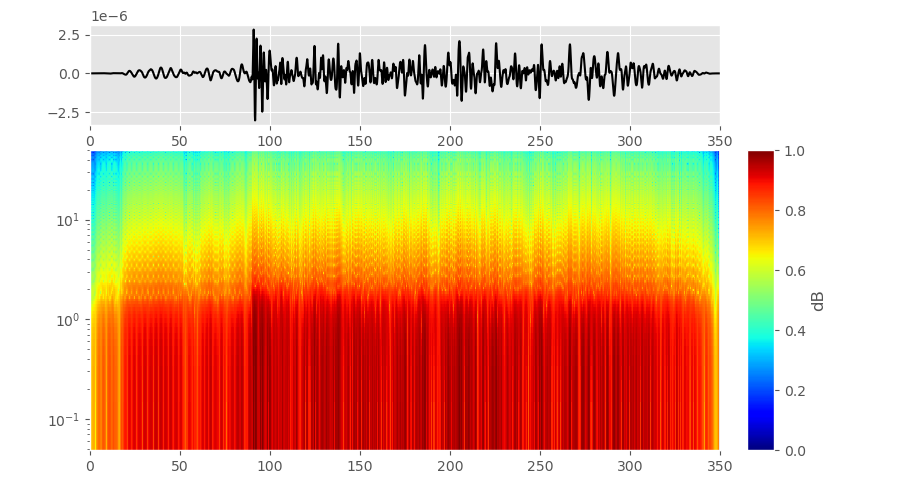

 Run this cell again (rtn= Not, and save results)?: 
 Resuls saved + a safety trace copy was created.


In [35]:
#
print(f"Enter the filter, lower freq., upper freq., filter order, zerophase: ftype, f0, f1, nc, zP")
print(f" Filter minimum options:")
print(f"                lp (lowpass)  -> f0         is required")
print(f"                hp (highpass) -> f0         is required")
print(f"                bp (bandpass) -> f0 and f1 are required")
print(f"                bs (bandstop) -> f0 and f1 are required")

ent = input(f' Enter ftype, f0, f1, nc and zP (dflt: Nc=4, zP=True): ')
ent = ent.rstrip().split(' ')

if ent[0] == 'lp' or ent[0] == 'hp':
    ent[0] = 'lowpass' if ent[0] == 'lp' else 'highpass'
    ent[1] = float(ent[1])
    ent[len(ent):] = [int(4), True] if len(ent) == 2 else [int(ent[2]), True] if len(ent) == 3 else [int(ent[2]), bool(ent[3])]

elif ent[0] == 'bp' or ent[0] == 'bs':
    ent[0]  = 'bandpass' if ent[0] == 'bp' else 'bandstop'
    ent[1:3] = [ float(dummy) for dummy in ent[1:3] ]
    ent[len(ent):] = [int(4), True] if len(ent) == 3 else [int(ent[3]), True] if len(ent) == 3 else [int(ent[3]), bool(ent[4])]

#\_______________________________________________________________________________________________________________/
#------- Acausal filter/zero phase if zP=True, otherwise a causal filter.
#--------  Filter data. Use aliases to make life easier
if len(ent) == 5:
    ftype, f0, f1, nc , zP = ent[:]
    trZ.filter(ftype, freqmin=f0, freqmax=f1, zerophase=zP, corners=nc)
else:
    ftype, f0, nc , zP = ent[:]
    f1 = None
    trZ.filter(ftype, freq=f0, zerophase=zP, corners=nc)

#-------- Data spectrogram
p.Pspect(time, trZ)

#--------  Reset to the last cell or save trace to the next cell + append to the processing flux

dummy = f0 if f1 is None else str(f0)+' '+str(f1)
dummy = ftype+' '+dummy

tr0, trZ, Pflux = u.AuxReset(tr0, trZ, lst=Pflux, app=[dummy])


---
